# Sequence to Sequence with Attention Mechanism

In this section, we add the attention mechanism to the sequence to sequence model introduced in Section 10.14 to explicitly select state. The following figure shows the model architecture for a decoding time step. As can be seen, the memory of the attention layer consists of the encoder outputs of each time step. During decoding, the decoder output from the previous time step is used as the query, the attention output is then fed into the decoder with the input to provide attentional context information.

The layer structure in the encoder and the decoder is shown in the following figure.

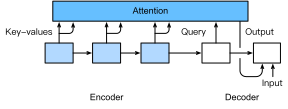

In [1]:
from IPython.display import SVG
SVG(filename= '../img/seq2seq_attention.svg')

Fig. 11.2.1: The second time step in decoding for the sequence to sequence model with attention mechanism.

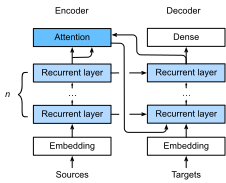

In [2]:
SVG(filename= '../img/seq2seq-attention-details.svg')

In [3]:
import sys
sys.path.insert(0, '..')

import d2l
import torch
import torch.nn as nn
from d2l import MLPAttention
from d2l import Seq2SeqEncoder

## Decoder

Now let’s implement the decoder of this model. We add a MLP attention layer which has the same hidden size as the
LSTM layer. The state passed from the encoder to the decoder contains three items: - the encoder outputs of all time steps, which are used as the attention layer’s memory with identical keys and values - the hidden state of the last time step that is used to initialize the encoder’s hidden state - valid lengths of the decoder inputs so the attention layer will not consider encoder outputs for padding tokens.

In each time step of decoding, we use the output of the last RNN layer as the query for the attention layer. Its output is then concatenated with the input embedding vector to feed into the RNN layer. Despite the RNN layer hidden state also contains history information from decoder, the attention output explicitly selects the encoder outputs that are correlated to the query and suspends other non-correlated information.

In [4]:
class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention_cell = MLPAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_layers, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_len, *args):
        outputs, hidden_state = enc_outputs
        # Transpose outputs to (batch_size, seq_len, hidden_size)
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_len)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs = []
        for x in X:
            # query shape: (batch_size, 1, hidden_size)
            query = hidden_state[0][-1].unsqueeze(1)
            print(enc_outputs.shape, query.shape)
            # context has same shape as query
            context = self.attention_cell(
            query, enc_outputs, enc_outputs, enc_valid_len)
            # concatenate on the feature dimension
            print(context.shape, x.unsqueeze(1).shape,'dfgh')
            x = torch.cat((context, x.unsqueeze(1)), dim=-1)
            # reshape x to (1, batch_size, embed_size+hidden_size)
            print(x.permute(1, 0, 2).shape)
            print(hidden_state[0].shape)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
        outputs = self.dense(nd.concat(*outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                        enc_valid_len]

Use the same hyper-parameters to create an encoder and decoder as the “Sequence to Sequence” section, we get the same decoder output shape, but the state structure is changed.

In [11]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8,
                             num_hiddens=16, num_layers=2)
# encoder.initialize()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8,
                                  num_hiddens=16, num_layers=2)
# decoder.initialize()
X = torch.zeros((4, 7), dtype=torch.int64)
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

torch.Size([4, 7, 16]) torch.Size([4, 1, 16])
torch.Size([4, 1, 16]) torch.Size([4, 1, 8]) dfgh
torch.Size([1, 4, 24])
torch.Size([2, 4, 16])


RuntimeError: Expected hidden[0] size (1, 4, 2), got (2, 4, 16)

## Training

Again, we use the same training hyper-parameters as in Section 10.14. The training loss is similar to the seq2seq model, because the sequences in the training dataset are relative short. The additional attention layer doesn’t lead to a significant different. But due to both attention layer computational overhead and we unroll the time steps in the decoder, this model is much slower than the seq2seq model.

In [ ]:
# embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
# batch_size, num_examples, max_len = 64, 1e3, 10
# lr, num_epochs, ctx = 0.005, 200, d2l.try_gpu()
# src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(
# batch_size, max_len, num_examples)
# encoder = d2l.Seq2SeqEncoder(
# len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
# decoder = Seq2SeqAttentionDecoder(
# len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
# model = d2l.EncoderDecoder(encoder, decoder)
# d2l.train_ch7(model, train_iter, lr, num_epochs, ctx)

Lastly, we predict several sample examples.

In [ ]:
# for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
#     print(sentence + ' => ' + d2l.translate_ch7(
#     model, sentence, src_vocab, tgt_vocab, max_len, ctx))